In [1]:
import subprocess
import os
os.environ['HF_HOME'] = '/root/autodl-tmp/cache/'

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value


In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

DATA = json.load(open("pair_qa.json", "r"))
DATA[0]

{'id': 1,
 'relevant_context': 'The capital of the fictional country Zorvath is Veldros. It is known for its towering crystal spires and floating markets.',
 'irrelevant_context': 'The Mars Rover Perseverance landed on Mars in 2021, searching for signs of ancient microbial life.',
 'question': 'What is the capital of Zorvath?',
 'answer': 'Veldros'}

In [4]:
# Load model and tokenizer

model_id = "qwen2-1.5b-chat"
tokenizer = AutoTokenizer.from_pretrained(model_id, max_length=6000)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    attn_implementation="eager",        # 👈 强制回退到 eager 实现
    output_attentions=True,             # 👈 显式启用 attention 返回
).cuda()
model.eval()

/root/miniconda3/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
Sliding Window Attention is enabled but not implemented for `eager`; unexpected results may be encountered.


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1536,), eps=1e-06)
    (rotary_emb): Qw

100%|██████████| 100/100 [00:03<00:00, 28.47it/s]
/tmp/ipykernel_23287/2789955685.py:93: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


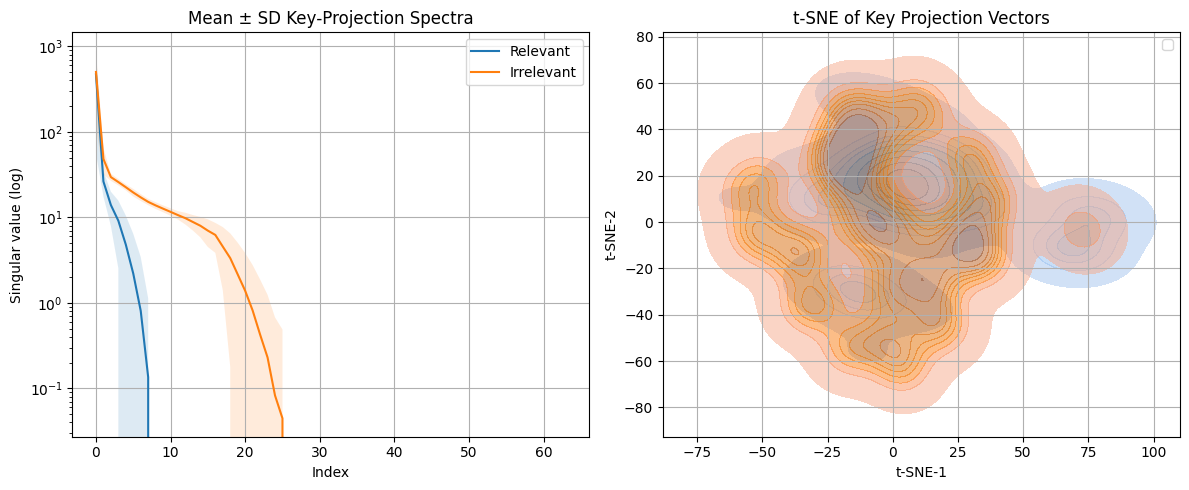

In [28]:
# ── prerequisites already defined ────────────────────────────────────────
# model      : Qwen2‑1.5B‑chat (AutoModelForCausalLM).eval().cuda()
# tokenizer  : matching fast tokenizer
# DATA       : list of dicts {relevant_context, irrelevant_context, question}
# ─────────────────────────────────────────────────────────────────────────

import random, torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.manifold import TSNE
from tqdm import tqdm

TOP_K = 64          # leading singular values kept for the spectrum plot
LAYER = 19          # layer to probe
SEED  = 42
random.seed(SEED); torch.manual_seed(SEED)

# ---------- helpers ------------------------------------------------------
def spans(text: str, sub: str):
    a, b = text.index(sub), text.index(sub) + len(sub)
    offs = tokenizer(text, return_offsets_mapping=True, add_special_tokens=False)["offset_mapping"]
    return [i for i, (s, e) in enumerate(offs) if s >= a and e <= b]

def svd_pad(mat, k=TOP_K):
    """Return top‑k singular values, zero‑padded to length k."""
    _, s, _ = torch.linalg.svd(mat, full_matrices=False)
    s = s[:k].cpu().detach().numpy()
    if len(s) < k:
        s = np.pad(s, (0, k - len(s)))
    return s

def analyse_pair(rel, irrel, q):
    # ---- randomise order ------------------------------------------------
    if random.random() < .5:
        ctx = f"{rel}\n{irrel}\nQuestion: {q}"
        idx_r, idx_i = spans(ctx, rel), spans(ctx, irrel)
    else:
        ctx = f"{irrel}\n{rel}\nQuestion: {q}"
        idx_i, idx_r = spans(ctx, irrel), spans(ctx, rel)

    enc = tokenizer(ctx, return_tensors="pt", add_special_tokens=False).to(model.device)
    with torch.no_grad():
        h = model(**enc, use_cache=False, output_hidden_states=True).hidden_states[LAYER][0]  # (seq, d_model)

    # ---- true key projections (handles GQA automatically) ---------------
    keys = model.model.layers[LAYER].self_attn.k_proj(h)   # (seq, kv_dim=256)

    keys_rel, keys_irrel = keys[idx_r], keys[idx_i]

    return (svd_pad(keys_rel), svd_pad(keys_irrel),
            keys_rel.cpu().detach().numpy(), keys_irrel.cpu().detach().numpy())

# ---------- loop over dataset -------------------------------------------
spec_r, spec_i, vecs, labels = [], [], [], []

for item in tqdm(DATA[:100]):
    s_r, s_i, k_r, k_i = analyse_pair(item["answer"],
                                      item["irrelevant_context"],
                                      item["question"])
    spec_r.append(s_r);   spec_i.append(s_i)
    vecs += [k_r, k_i]
    labels += ["Relevant"] * len(k_r) + ["Irrelevant"] * len(k_i)

spec_r, spec_i = np.stack(spec_r), np.stack(spec_i)         # (samples, TOP_K)
vecs = np.concatenate(vecs)                                 # (tokens, kv_dim)

# ---------- plots (original layout) -------------------------------------
plt.figure(figsize=(12, 5))
x = np.arange(TOP_K)

# spectra
plt.subplot(1, 2, 1)
μr, σr = spec_r.mean(0), spec_r.std(0)
μi, σi = spec_i.mean(0), spec_i.std(0)
plt.fill_between(x, μr - σr, μr + σr, alpha=.15)
plt.plot(x, μr, label="Relevant")
plt.fill_between(x, μi - σi, μi + σi, alpha=.15)
plt.plot(x, μi, label="Irrelevant")
plt.yscale("log"); plt.xlabel("Index"); plt.ylabel("Singular value (log)")
plt.title("Mean ± SD Key‑Projection Spectra"); plt.grid(True); plt.legend()

# t‑SNE
tsne = TSNE(n_components=2,
            perplexity=min(30, len(vecs) - 1),
            init="pca",
            random_state=SEED)
emb = tsne.fit_transform(vecs)
plt.subplot(1, 2, 2)
for lab in ("Relevant", "Irrelevant"):
    idx = [i for i, l in enumerate(labels) if l == lab]
    sns.kdeplot(x=emb[idx, 0], y=emb[idx, 1], fill=True, alpha=.5,
                levels=10, thresh=.01, label=lab)
plt.title("t‑SNE of Key Projection Vectors")
plt.xlabel("t‑SNE‑1"); plt.ylabel("t‑SNE‑2")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
